In [ ]:
# import Pkg; Pkg.add("JuMPeR")
# Pkg.add("Compat")
# import Pkg; Pkg.add("Ipopt")
https://www.linkedin.com/pulse/competitive-pricing-strategy-uncovered-from-execution-chirag-lakum/

In [1]:
using CSV, DataFrames
using JuMP, Gurobi
#using JuMPeR
using Ipopt
using Plots
#using IpoptSolver

In [2]:
retail = "./Data/generated_data_complete.csv" #468×13 DataFrame
retail = DataFrame(CSV.File(retail));
retail

Row,Column1,product_id,month,qty,freight_price,unit_price,customers,comp_1,fp1,comp_2,fp2,comp_3,fp3
,Int64,String15,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,11,bed1,1,5.0,13.6219,41.2668,88.0,88.9405,21.1437,143.089,18.377,44.0345,13.8498
2,10,bed1,2,6.0,13.4136,41.6165,56.0,89.8649,16.9539,83.4357,19.5907,45.4928,14.7841
3,8,bed1,3,10.0,14.1062,43.6091,120.0,89.2926,19.3734,62.9036,22.6992,44.6849,12.9731
4,9,bed1,4,7.0,13.0714,45.7578,52.0,89.7734,19.5056,158.042,19.6394,42.6914,13.2125
5,0,bed1,5,1.0,15.1,45.95,57.0,89.9,15.0119,215.0,8.76,45.95,15.1
6,1,bed1,6,3.0,12.9333,45.95,61.0,89.9,14.7692,209.0,21.322,45.95,12.9333
7,2,bed1,7,6.0,14.84,45.95,123.0,89.9,13.9938,205.0,22.1959,45.95,14.84
8,3,bed1,8,4.0,14.2875,45.95,90.0,89.9,14.6568,199.51,19.4129,45.95,14.2875
9,4,bed1,9,2.0,15.1,45.95,54.0,89.9,18.7765,163.399,24.3247,45.95,15.1


In [3]:
num_rows = size(retail)[1] # 468
num_month = 12
num_product = length(unique(retail[!,"product_id"])) # 
print("There are ", num_product, " number of product")

There are 39 number of product

In [4]:
demand = retail[!,"customers"]
cost = retail[!,"freight_price"]

C1 = retail[!,"comp_1"]
C2 = retail[!,"comp_2"]
C3 = retail[!,"comp_3"]

com1_cost = retail[!,"fp1"]
com2_cost = retail[!,"fp2"]
com3_cost = retail[!,"fp3"];

In [5]:
ori_price = retail[!,"unit_price"]
ori_price = reshape(ori_price, 12, 39)  # Reshape by column (12 columns, 39 rows)
ori_price = permutedims(ori_price)

39×12 Matrix{Float64}:
  41.2668   41.6165   43.6091   45.7578  …   45.95     40.5318   39.99
  89.64     89.9      89.9      89.9         89.9      89.9      88.4882
 167.679   195.451   189.648   208.187      166.636   188.662   180.819
 104.113   109.512    95.7228   98.6572      98.9      98.9      98.9
 150.016   154.242   167.137   157.994      137.9     137.9     134.9
 140.036   159.99    159.99    139.99    …  154.696   149.99    149.99
  23.693    21.6806   21.6762   22.6455      21.5429   24.5      24.5
  20.8786   20.8602   20.9902   23.5694      20.6667   24.5      24.5
  99.5182   85.7043   99.99     99.99        99.99     99.99     99.99
 125.526   126.937   129.99    129.99       119.99    129.99    129.99
 149.323   154.875   154.526   146.795   …  146.99    157.36    166.99
  99.99     99.99     99.99     99.99        99.99     99.99     99.99
  37.9739   36.9309   38.1177   37.1977      38.4      36.8543   37.8462
   ⋮                                     ⋱           

In [6]:
demand = reshape(demand, 12, 39)  # Reshape by column (12 columns, 39 rows)
demand = permutedims(demand)  # Reshape by row

cost = reshape(cost, 12, 39)  # Reshape by column (12 columns, 39 rows)
cost = permutedims(cost)  # Reshape by row

C1 = reshape(C1, 12, 39)  # Reshape by column (12 columns, 39 rows)
C1 = permutedims(C1)  # Reshape by row

C2 = reshape(C2, 12, 39)  # Reshape by column (12 columns, 39 rows)
C2 = permutedims(C2)  # Reshape by row

C3 = reshape(C3, 12, 39)  # Reshape by column (12 columns, 39 rows)
C3 = permutedims(C3);  # Reshape by row

# Optimization Model 1

In [11]:
function model1()
    model = Model(Ipopt.Optimizer)

    @variable(model, Z[1:num_product,0:num_month] >= 0)
    
    @NLobjective(model, Max, 
        sum(sum((Z[i,t]-cost[i,t])*(demand[i,t]*exp(-(3*Z[i,t]/(C1[i,t]+C2[i,t]+C3[i,t])))^2) for i in 1:num_product) for t in 1:num_month))

    @constraint(model, [i in 1:num_product], Z[i,0] == ori_price[i,1])
    for t in 1:num_month
        @constraint(model, [i in 1:num_product], Z[i,t] <= 1.05*Z[i,t-1])
        #@constraint(model,sum(Z[i,t] for i in 1:num_product)==150)
    end
    
    optimize!(model);
    objective = objective_value(model)
    return objective, value.(Z)
end
out = model1();

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:       39
Number of nonzeros in inequality constraint Jacobian.:      936
Number of nonzeros in Lagrangian Hessian.............:      468

Total number of variables............................:      507
                     variables with only lower bounds:      507
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       39
Total number of inequality constraints...............:      468
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      468

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -7.3452478e+05 3.50e+02 6.83e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [12]:
obj, Z = out
print("the maximum revenue with optimized pricing is ", Int(round(obj, digits=0)), "\n")
Z

the maximum revenue with optimized pricing is 301751


2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, Base.OneTo(39)
    Dimension 2, 0:12
And data, a 39×13 Matrix{Float64}:
  41.2668   43.3302   45.4967   47.7715  …   45.4      44.3267   43.308
  89.64     55.8963   58.6911   61.6257      59.1971   53.016    55.0594
 167.679    79.4095   74.8114   71.4089      68.3895   63.8506   63.6194
 104.113    71.8935   69.5343   71.442       75.8718   75.9383   73.5083
 150.016   103.36    108.528   110.238      106.9     105.697   104.578
 140.036   118.677   113.395   113.395   …  121.229   110.831   106.883
  23.693    24.8776   26.1215   26.6849      24.4624   25.6855   25.1237
  20.8786   21.9226   22.92     23.0908      24.1224   25.3286   25.7747
  99.5182   62.3601   65.4781   68.752       67.6881   71.0725   70.2617
 125.526    77.9771   81.876    78.7738      77.8466   81.7389   85.585
 149.323    82.8572   80.764    82.7039  …   81.2437   85.3058   89.5711
  99.99     67.3526   64.0865   67.2908      69.240

In [13]:
opt_price = DataFrame(collect(Z),:auto)[!,2:13];

In [ ]:
proj_sale_qty = demand[i,t]*exp(-(3*opt_price[i,t]/(C1[i,t]+C2[i,t]+C3[i,t])))^2

In [ ]:
for i in 1:1
    for j in 1:12

In [14]:
demand

39×12 Matrix{Float64}:
  88.0  56.0  120.0  52.0  57.0  61.0  123.0  90.0  54.0   50.0   97.0   41.0
  92.0   2.0   20.0  31.0  57.0  61.0  123.0  90.0  54.0   50.0   97.0   41.0
 112.0  89.0  113.0  73.0  57.0  61.0  123.0  90.0  54.0  119.0   85.0   99.0
  18.0  14.0   20.0  29.0  11.0  15.0   17.0  15.0  15.0   31.0   36.0   35.0
  21.0  20.0   17.0  31.0  11.0  15.0   17.0  15.0  15.0   31.0   36.0   35.0
  19.0   3.0    3.0   5.0  15.0  15.0   17.0  15.0  15.0   31.0   36.0   35.0
  15.0  36.0   18.0  32.0  30.0  34.0   13.0  33.0  17.0   38.0   49.0   30.0
  32.0  47.0   31.0  48.0  35.0  35.0   13.0  33.0  17.0   38.0   49.0   30.0
  32.0   7.0   22.0  33.0  58.0  42.0   42.0  39.0  10.0   33.0   42.0   38.0
  37.0  46.0   22.0  33.0  58.0  42.0   42.0  39.0  37.0   33.0   42.0   38.0
  33.0  33.0   40.0  34.0  35.0  34.0   42.0  39.0  34.0   33.0   42.0   38.0
  37.0  25.0   21.0  33.0  58.0  42.0   42.0  39.0  10.0   33.0   42.0   38.0
  30.0  36.0   39.0  53.0  22.0  25.0    

# Model2

In [39]:
function model2()
    model = Model(Ipopt.Optimizer)

    @variable(model, Z[1:num_product,0:num_month] >= 0)
    
    @NLobjective(model, Max, 
        sum(sum((Z[i,t]-cost[i,t])*(demand[i,t]*exp(-(3*Z[i,t]/(C1[i,t]+C2[i,t]+C3[i,t])))^2) for i in 1:num_product) for t in 1:num_month))

    @constraint(model, [i in 1:num_product], Z[i,0] == ori_price[i,1])
    for t in 1:num_month
        @constraint(model, [i in 1:num_product], Z[i,t] <= 1.05*Z[i,t-1])
        # @NLconstraint(model, sum(demand[i,t]*exp(-(3*Z[i,t]/(C1[i,t]+C2[i,t]+C3[i,t])))^2 for i in 1:num_product)<=390)
    end
    @constraint(model, [i in 1:num_product], Z[i,num_month] <= 1.35*Z[i,1])
    
    optimize!(model);
    objective = objective_value(model)
    return objective, value.(Z)
end
out2 = model2();

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:       39
Number of nonzeros in inequality constraint Jacobian.:     1014
Number of nonzeros in Lagrangian Hessian.............:      468

Total number of variables............................:      507
                     variables with only lower bounds:      507
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       39
Total number of inequality constraints...............:      507
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      507

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -7.3452478e+05 3.50e+02 6.58e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [40]:
obj, Z = out2
print("the maximum revenue with optimized pricing is ", Int(round(obj, digits=0)), "\n")
Z

the maximum revenue with optimized pricing is 301702


2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, Base.OneTo(39)
    Dimension 2, 0:12
And data, a 39×13 Matrix{Float64}:
  41.2668   43.3302   45.4967   47.7715  …   45.4      44.3267   43.308
  89.64     55.8963   58.6911   61.6257      59.1971   53.016    55.0594
 167.679    79.4095   74.8114   71.4089      68.3895   63.8506   63.6194
 104.113    71.8935   69.5343   71.442       75.8718   75.9383   73.5083
 150.016   103.36    108.528   110.238      106.9     105.697   104.578
 140.036   118.677   113.395   113.395   …  121.229   110.831   106.883
  23.693    24.8776   26.1215   26.6849      24.4624   25.6855   25.1237
  20.8786   21.9226   22.92     23.0908      24.1224   25.3286   25.7747
  99.5182   62.3601   65.4781   68.752       67.6881   71.0725   70.2617
 125.526    77.9771   81.876    78.7738      77.8466   81.7389   85.585
 149.323    82.8572   80.764    82.7039  …   81.2437   85.3058   89.5711
  99.99     67.3526   64.0865   67.2908      69.240

## Model 3

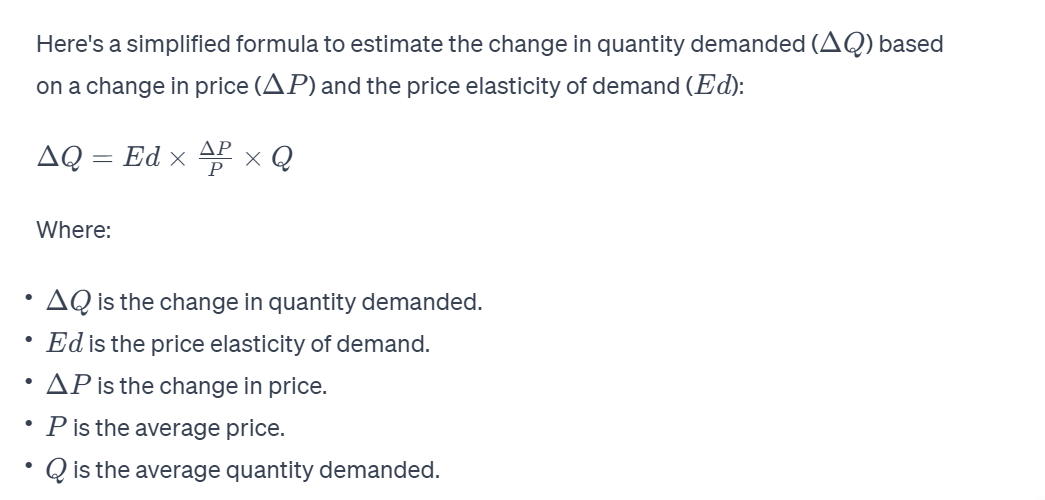

In [51]:
function model3()
    model = Model(Ipopt.Optimizer)

    @variable(model, Z[1:num_product,0:num_month] >= 0)
    
    @NLobjective(model, Max, 
        sum(sum((Z[i,t]-cost[i,t])*(demand[i,t]*-2*(3Z[i,t]/(C1[i,t]+C2[i,t]+C3[i,t]))) for i in 1:num_product) for t in 1:num_month))

    @constraint(model, [i in 1:num_product], Z[i,0] == ori_price[i,1])
    for t in 1:num_month
        @constraint(model, [i in 1:num_product], Z[i,t] <= 1.05*Z[i,t-1])
    end
    #@constraint(model, [i in 1:num_product], Z[i,num_month] <= 1.35*Z[i,1])

    optimize!(model);
    objective = objective_value(model)
    return objective, value.(Z)
end
out3 = model3();

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:       39
Number of nonzeros in inequality constraint Jacobian.:      936
Number of nonzeros in Lagrangian Hessian.............:      468

Total number of variables............................:      507
                     variables with only lower bounds:      507
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       39
Total number of inequality constraints...............:      468
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      468

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2227471e+02 3.50e+02 6.60e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [52]:
obj, Z = out3
print("the maximum revenue with optimized pricing is ", Int(round(obj, digits=0)), "\n")
Z

the maximum revenue with optimized pricing is 143129


2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, Base.OneTo(39)
    Dimension 2, 0:12
And data, a 39×13 Matrix{Float64}:
  41.2668   6.81094   6.71435   7.05007  …   7.55      7.91636   7.615
  89.64     7.38923   6.69941   7.03438      9.08791   8.42075   8.84178
 167.679   11.5081    9.7389    7.7055       5.91999   5.74536   5.18866
 104.113    6.59532   6.92509   7.01373      7.65945   8.04242   6.855
 150.016   14.2054   14.9156   15.6614      16.6393   17.4712   18.3448
 140.036   22.7176   17.0216   17.8726   …  21.7664   21.2586   19.285
  23.693    7.44283   7.81498   7.91064      6.76714   6.82268   6.43687
  20.8786   6.09061   6.07784   6.12257      6.4562    6.77901   6.76235
  99.5182  10.7627   10.9857    8.32214      8.44452   8.09375   7.63333
 125.526   10.4496   10.9721    9.38938     10.5811   11.1102   11.6657
 149.323   10.8519    9.57486  10.0536   …   9.57702  10.0559   10.5587
  99.99     8.48826   8.91267   9.35831      9.25944   8

In [48]:
cost

39×12 Matrix{Float64}:
 13.6219  13.4136   14.1062   13.0714  …  15.1      15.1     15.8327  15.23
 14.7785  13.02     13.6527   15.05       18.7765   21.5721  16.294   18.8983
 23.0162  19.4778   14.9973   10.4408     24.3247   11.84    11.4907  10.3773
 12.4601  14.6758   13.6286   13.9584     14.975    17.1225  16.14    13.71
 22.3586  36.7577   31.5578   26.875      35.9225   36.0219  39.3989  38.78
 45.4351  33.4      33.4      35.122   …  43.7227   43.8812  42.5172  38.57
 14.1108  15.9236   15.8213   14.9919     16.1333   13.5343  13.6454  12.8737
 12.1812  12.1557   12.2451   12.597      15.4111   12.8033  13.6522  13.5247
 21.5255  21.9714   16.6443   14.2024     15.9333   16.95    16.1875  15.2667
 17.4335  24.6954   18.7787   17.3964     18.3772   19.997   22.6744  25.59
 21.7037  17.8353   21.1179   17.6405  …  16.47     18.755   20.837   24.4714
 15.8314  17.8683   18.1895   21.17       17.7817   18.5189  17.45    17.95
 15.0033   9.19352  13.0874   15.6435     17.95     1

# Model4

In [12]:
function model4(uncer)
    model = Model(Ipopt.Optimizer)

    @variable(model, Z[1:num_product,1:num_month] >= 0)
    
    @NLobjective(model, Max, 
        sum(sum((Z[i,t]-cost[i,t])*(demand[i,t]*exp(-(3*Z[i,t]/((C1[i,t]+C2[i,t]+C3[i,t])*(1+uncer))))^2) for i in 1:num_product) for t in 1:num_month))

    #@constraint(model, [i in 1:num_product], Z[i,0] == ori_price[i,1])
    for t in 1:num_month
        if t != 1
            @constraint(model, [i in 1:num_product], Z[i,t] <= 1.05*Z[i,t-1])
        end
        #@NLconstraint(model, [t in 1:num_month],sum((demand[i,t]*exp(-(3*Z[i,t]/((C1[i,t]+C2[i,t]+C3[i,t])*1)))^2) for i in 1:num_product)<=150)
    end
    
    optimize!(model);
    objective = objective_value(model)
    return objective, value.(Z)
end

model4 (generic function with 1 method)

In [13]:
obj, Z = model4(0)
print("the maximum revenue with optimized pricing is ", Int(round(obj, digits=0)), "\n")
Z


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      858
Number of nonzeros in Lagrangian Hessian.............:      468

Total number of variables............................:      468
                     variables with only lower bounds:      468
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

39×12 Matrix{Float64}:
  59.6325   54.3151   57.0309   59.8824  …   45.4      44.3267   43.308
  55.8963   58.6911   61.6257   64.707       59.1971   53.016    55.0594
  79.4095   74.8114   71.4089   66.8111      68.3895   63.8506   63.6194
  71.8935   69.5343   71.442    72.1495      75.8718   75.9383   73.5083
 103.36    108.528   110.238   102.446      106.9     105.697   104.578
 118.677   113.395   113.395   105.695   …  121.229   110.831   106.883
  25.1655   26.4238   26.6849   26.5634      24.4624   25.6855   25.1237
  23.2689   22.92     23.0908   23.3145      24.1224   25.3286   25.7747
  62.3601   65.4781   68.752    69.1974      67.6881   71.0725   70.2617
  77.9771   81.876    78.7738   77.3914      77.8466   81.7389   85.585
  82.8572   80.764    82.7039   81.8826  …   81.2437   85.3058   89.5711
  67.3526   64.0865   67.2908   70.6553      69.2408   72.445    72.945
  45.0269   40.1659   42.1742   44.2829      44.1605   46.3685   42.0529
   ⋮                             

## Baseline Model

In [30]:
size(retail)[1]

468

In [95]:
baseline_rev = 0
for i in 1:size(retail)[1]
    # print()
    total_demand = retail[i,"customers"]
    baseline_price = retail[i,"unit_price"]
    baseline_cost = retail[i,"freight_price"]
    comp1_price = retail[i,"comp_1"]
    comp2_price = retail[i,"comp_2"]
    comp3_price = retail[i,"comp_3"]
    #sum(sum((Z[i,t]-cost[i,t])*(demand[i,t]*exp(-(Z[i,t]/(C1[i,t]+C2[i,t]+C3[i,t])))^2) for i in 1:num_product) for t in 1:num_month))

    baseline_sale = total_demand*exp(-3*baseline_price/(comp1_price+comp2_price+comp3_price))^2
    #print(baseline_sale, "\n")
    baseline_profit = baseline_price-baseline_cost
    
    baseline_rev+=baseline_profit*baseline_sale
end


In [96]:
baseline_rev

221008.3479587794

## Plots

In [27]:

for row in 1:39
    plot1 = plot(1:12, collect(values(opt_price[row,:])), label="Optimized_Pricing", xlabel="Month", ylabel="Price", 
        title="Optimized vs Baseline vs Competitor Pricing for Product $row", legendfont=8, titlefont=8)
    plot!(1:12, collect(values(C1[row,:])), label="Competitor1_Pricing")
    plot!(1:12, collect(values(C2[row,:])), label="Competitor2_Pricing")
    plot!(1:12, collect(values(C3[row,:])), label="Competitor3_Pricing")
    plot!(1:12, collect(values(ori_price[row,:])), label="Baseline_Pricing")
    #savefig("plot_$row.pdf")
    savefig("product_$row opt_baseline_comp.png")
end


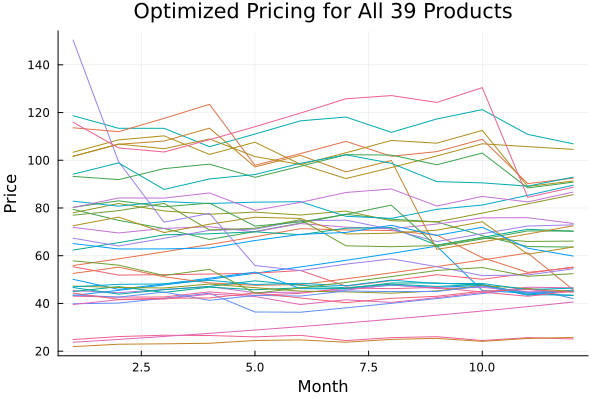

"C:\\Users\\nuobe\\Desktop\\MITclass_Optimization\\Project\\all_product_opt_price.png"

In [208]:
plot(legend=-1)
for row in 1:39
    plot!(1:12, collect(values(opt_price[row,:])), label="Line Plot", xlabel="Month", ylabel="Price", title="Optimized Pricing for All 39 Products")
end
display(plot!())
savefig("all_product_opt_price.png")

In [7]:
print(demand[1,:], '\n')
print(cost[1,:], '\n')
print(ori_price[1,:], '\n')
print(opt_price[1,:], '\n')
print(C1[1,:], '\n')
print(C2[1,:], '\n')
print(C3[1,:], '\n')

[88.0, 56.0, 120.0, 52.0, 57.0, 61.0, 123.0, 90.0, 54.0, 50.0, 97.0, 41.0]
[13.621882369948098, 13.413577434345218, 14.10618101864761, 13.071364022463783, 15.1, 12.93333333, 14.84, 14.2875, 15.1, 15.1, 15.83272727, 15.23]
[41.26681876660176, 41.61653094215304, 43.60909154298178, 45.75775106815832, 45.95, 45.95, 45.95, 45.95, 45.95, 45.95, 40.53181818, 39.99]


LoadError: UndefVarError: `opt_price` not defined

# For individual product, calculate the baseline or opt revenue

In [101]:
baseline_rev = 0
for i in 1:12
    # print()
    total_demand = retail[i,"customers"]
    baseline_price = retail[i,"unit_price"]
    baseline_cost = retail[i,"freight_price"]
    comp1_price = retail[i,"comp_1"]
    comp2_price = retail[i,"comp_2"]
    comp3_price = retail[i,"comp_3"]
    #sum(sum((Z[i,t]-cost[i,t])*(demand[i,t]*exp(-(Z[i,t]/(C1[i,t]+C2[i,t]+C3[i,t])))^2) for i in 1:num_product) for t in 1:num_month))

    baseline_sale = total_demand*exp(-3*baseline_price/(comp1_price+comp2_price+comp3_price))^2
    #print(baseline_sale, "\n")
    baseline_profit = baseline_price-baseline_cost
    
    baseline_rev+=baseline_profit*baseline_sale
end
baseline_rev

9581.573390803067

In [40]:
opt_price=DataFrame(opt_price);

In [38]:
# opt_price[1,:]

In [94]:
opt_rev = 0
for i in 1:1
    for j in 1:12
    # print()
        total_demand = demand[i,j]
        optimal_price = opt_price[i,j]
        baseline_cost = cost[i,j]
        comp1_price = C1[i,j]
        comp2_price = C2[i,j]
        comp3_price = C3[i,j]
        avg_comp_price = (comp1_price+comp2_price+comp3_price)/3
        #sum(sum((Z[i,t]-cost[i,t])*(demand[i,t]*exp(-(Z[i,t]/(C1[i,t]+C2[i,t]+C3[i,t])))^2) for i in 1:num_product) for t in 1:num_month))
    
        # opt_sale = total_demand*exp(-3*optimal_price/(comp1_price+comp2_price+comp3_price))^2
        opt_sale = total_demand*exp(-optimal_price/avg_comp_price)^2
        #print(baseline_sale, "\n")
        opt_profit = optimal_price-baseline_cost
        
        opt_rev+=opt_profit*opt_sale
        print("opt_sale: ",opt_profit, "optimal_price: ", optimal_price, "cost ", baseline_cost, " ",total_demand, " ", avg_comp_price, " ", opt_rev, "\n")
    end
end
opt_rev

opt_sale: 29.708277344575166optimal_price: 43.33015971452326cost 13.621882369948098 88.0 92.02124384496933 1019.4514680285885
opt_sale: 32.083090275361116optimal_price: 45.49666770970633cost 13.413577434345218 56.0 72.93111703968009 1535.4064185859775
opt_sale: 33.6653200859473optimal_price: 47.77150110459491cost 14.10618101864761 120.0 65.62703911178022 2477.5068105286923
opt_sale: 37.088712146745586optimal_price: 50.16007616920937cost 13.071364022463783 52.0 96.83573957424979 3161.9281166720803
opt_sale: 37.56807998694202optimal_price: 52.66807998694202cost 15.1 57.0 116.94999999999999 4031.9445058465067
opt_sale: 42.3681506652636optimal_price: 55.301483995263595cost 12.93333333 61.0 114.94999999999999 5019.3566264160945
opt_sale: 43.22655820356049optimal_price: 58.06655820356048cost 14.84 123.0 113.61666666666666 6932.47689804093
opt_sale: 46.68238611926248optimal_price: 60.96988611926248cost 14.2875 90.0 111.78660130000002 8343.895001948762
opt_sale: 48.9183803527872optimal_price: 

10243.858427796109

In [92]:
# Objective function: f(x) = (x - l) * d * (exp(-x / c))^2
function ob(x, l, d, c)
    result = 0
    for i in 1:length(x)
        profit = x[i] - l[i]
        sale_qty = d[i] * exp(-x[i] / c[i])^2
        result += profit * sale_qty
        print("opt_sale: ",profit, "optimal_price: ", x[i], "cost ", l[i], " ", d[i], " ", c[i], " ", result, "\n")
    end
    return result
end

ob (generic function with 1 method)

In [99]:
print(x)

DataFrameRow
 Row │ x2       x3       x4       x5       x6       x7       x8       x9       x10      x11      x12      x13     
     │ Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64 
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 43.3302  45.4967  47.7715  50.1601  52.6681  55.3015  58.0666  60.9699  64.0184     45.4  44.3267   43.308

In [81]:
d = demand[1,:]
x = opt_price[1,:]
l = cost[1,:]
c = comp1_price = (C1[1,:] .+ C2[1,:] .+ C3[1,:])./3;

In [93]:
result = ob(x,l,d,c)
result

opt_sale: 29.708277344575166optimal_price: 43.33015971452326cost 13.621882369948098 88.0 92.02124384496933 1019.4514680285885
opt_sale: 32.083090275361116optimal_price: 45.49666770970633cost 13.413577434345218 56.0 72.93111703968009 1535.4064185859775
opt_sale: 33.6653200859473optimal_price: 47.77150110459491cost 14.10618101864761 120.0 65.62703911178022 2477.5068105286923
opt_sale: 37.088712146745586optimal_price: 50.16007616920937cost 13.071364022463783 52.0 96.83573957424979 3161.9281166720803
opt_sale: 37.56807998694202optimal_price: 52.66807998694202cost 15.1 57.0 116.94999999999999 4031.9445058465067
opt_sale: 42.3681506652636optimal_price: 55.301483995263595cost 12.93333333 61.0 114.94999999999999 5019.3566264160945
opt_sale: 43.22655820356049optimal_price: 58.06655820356048cost 14.84 123.0 113.61666666666666 6932.47689804093
opt_sale: 46.68238611926248optimal_price: 60.96988611926248cost 14.2875 90.0 111.78660130000002 8343.895001948762
opt_sale: 48.9183803527872optimal_price: 

10243.858427796109

#### WO Optimization, the approach could be price our product purely on competitor's price
1. Use the avg of the 3 competitor's price
2. Max of the competitor's price
3. Min of the competitor's price

In [22]:
#### AVG OF COMPETITOR"S PRICE

In [33]:
rev1 = 0
for i in 1:39
    for j in 1:12
        total_demand = demand[i,j]
        baseline_cost = cost[i,j]
        comp1_price = C1[i,j]
        comp2_price = C2[i,j]
        comp3_price = C3[i,j]
        avg_comp_price = (comp1_price+comp2_price+comp3_price)/3
        preopt_price_v1 = avg_comp_price # This will be changed in each comparision model
        sale_qty = total_demand*exp(-preopt_price_v1/avg_comp_price)^2
        profit = preopt_price_v1-baseline_cost
        
        rev1+=profit*sale_qty
    end
end
rev1

264249.7894032281

In [34]:
rev2 = 0
for i in 1:39
    for j in 1:12
        total_demand = demand[i,j]
        baseline_cost = cost[i,j]
        comp1_price = C1[i,j]
        comp2_price = C2[i,j]
        comp3_price = C3[i,j]
        avg_comp_price = (comp1_price+comp2_price+comp3_price)/3
        preopt_price_v2 = maximum([comp1_price,comp2_price,comp3_price]) # This will be changed in each comparision model
        sale_qty = total_demand*exp(-preopt_price_v2/avg_comp_price)^2
        profit = preopt_price_v2-baseline_cost
        
        rev2+=profit*sale_qty
    end
end
rev2

208267.8717689075

In [35]:
rev3 = 0
for i in 1:39
    for j in 1:12
        total_demand = demand[i,j]
        baseline_cost = cost[i,j]
        comp1_price = C1[i,j]
        comp2_price = C2[i,j]
        comp3_price = C3[i,j]
        avg_comp_price = (comp1_price+comp2_price+comp3_price)/3
        preopt_price_v3 = minimum([comp1_price,comp2_price,comp3_price]) # This will be changed in each comparision model
        sale_qty = total_demand*exp(-preopt_price_v3/avg_comp_price)^2
        profit = preopt_price_v3-baseline_cost
        
        rev3+=profit*sale_qty
    end
end
rev3

262679.6953687531